In [3]:
# import packages
import geopandas as gpd
import pandas as pd
import pandana
import momepy
import matplotlib.pyplot as plt
import seaborn as sns

import contextily
import plotly.express as px
from ipyleaflet import Map, GeoJSON, GeoData, basemaps, LayersControl
from matplotlib_scalebar.scalebar import ScaleBar

## Data loading

In [4]:
# load data

pois = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/pois.gpkg')
parks = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/greenspaces_access.gpkg')
postcodes = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/codepoint.gpkg')
walk_streets = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/walk_streets.gpkg')


## Data cleaning

In [5]:
## clean data

# clean street network
walk_streets = walk_streets[["geometry", "from", "to", "length"]] # clean columns

# clean postcodes
postcodes = postcodes.explode().reset_index(drop=True) # avoid multipart postcodes
postcodes['postcodeID'] = range(0,len(postcodes))
postcodes = postcodes.set_index('postcodeID') # set index

# clean pois
pois = pois.explode().reset_index(drop=True) # avoid multipart pois

amenities = ['Bakeries','Butchers','Confectioners','Delicatessens','Fishmongers','Grocers, Farm Shops and Pick Your Own','Convenience Stores and Independent Supermarkets','Supermarket Chains',
             'Bus Stops','Railway Stations, Junctions and Halts',
             'Gymnasiums, Sports Halls and Leisure Centres','Sport and Entertainment'
             'Higher Education Establishments','First, Primary and Infant Schools','Broad Age Range and Secondary State Schools',
             'Doctors Surgeries','Hospitals','Chemists and Pharmacies',
             'Cinemas','Theatres and Concert Halls','Art Galleries'] # select which amenities to keep
pois_filtered = pois[pois.classname.isin(amenities)] # filter amenities
pois_filtered = pois_filtered[['groupname','categoryname','classname','geometry']] # clean columns
pois_filtered['poiID'] = range(0,len(pois_filtered)) # generate index column
pois_filtered = pois_filtered.set_index('poiID') # set index column

# parks
parks = parks.reset_index(drop=True).explode().reset_index(drop=True) # clean
parks['parksID'] = range(0,len(parks)) # generate index column
parks = parks.set_index('parksID') # set index

# join pois and parks
df_list = [pois_filtered, parks]
destinations = gpd.GeoDataFrame(pd.concat(df_list, ignore_index=True))
destinations = destinations.reset_index().rename(columns={'index':'poiID'}) # set a unique ID for each poi

C:\Users\b9066009\AppData\Local\Temp\ipykernel_16148\3333041556.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  postcodes = postcodes.explode().reset_index(drop=True) # avoid multipart postcodes
C:\Users\b9066009\AppData\Local\Temp\ipykernel_16148\3333041556.py:12: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  pois = pois.explode().reset_index(drop=True) # avoid multipart pois
C:\Users\b9066009\AppData\Local\Temp\ipykernel_16148\3333041556.py:26: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/

## Pandana network

In [6]:
## generate pandana network
# nodes and edges for walk network
nodes_walk, edges_walk = momepy.nx_to_gdf( # convert network to gdf
    momepy.gdf_to_nx( # convert to nx graph
        walk_streets.explode() # remove multipart rows
    )
)
nodes_walk = nodes_walk.set_index('nodeID') # set index

# generate walk pandana network
walk_streets_pdna = pandana.Network( 
    nodes_walk.geometry.x,
    nodes_walk.geometry.y,
    edges_walk['node_start'], # set origins
    edges_walk['node_end'], # set destinations
    edges_walk[['mm_len']] # set edge length
)

C:\Users\b9066009\AppData\Local\Temp\ipykernel_16148\1369973530.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  walk_streets.explode() # remove multipart rows


### Analysis for adults

In [7]:
# attach pois to the network
walk_streets_pdna.set_pois( # snap pois to network
    category = 'destinations_adults', # set name of the new layer snapped on the network
    maxdist = 1125, # set maximum distance
    maxitems = 700, # set maximum number of pois to look for
    x_col = destinations.geometry.x,
    y_col = destinations.geometry.y
)

results_adults = walk_streets_pdna.nearest_pois( # calculate distances to pois
    distance = 1125, # maximum distance
    category = 'destinations_adults', # layer where we want to look for
    num_pois = 700, # max number of pois to look for
    include_poi_ids = True # include pois ids
)

# separate distances from poi ids
distances_adults = results_adults.iloc[:,:round(len(results_adults.columns)/2,)] # create df with distances
pois_ids_adults = results_adults.iloc[:,round(len(results_adults.columns)/2,):] # create df with pois ids

# convert wide matrices to long
distances_long_adults = pd.melt(distances_adults.reset_index(), id_vars='nodeID', value_name='distance')[['nodeID','distance']] # make matrix long
pois_ids_long_adults = pd.melt(pois_ids_adults.reset_index(), id_vars='nodeID', value_name='poiID')[['nodeID','poiID']] # make matrix long

# create an od long df containing nodeID, distance, and poiID
od_adults = distances_long_adults
od_adults['poiID'] = pois_ids_long_adults['poiID'].astype('Int64') # set a column with pois ids (as they are indexed, they are already in the right order)

# format od matrix and drop NAs
od_adults = od_adults.dropna() # drop NAs

# add destinations' info
od_pois_info_adults = pd.merge(od_adults,destinations)

# keep unique parks ids
od_pois_info_adults = od_pois_info_adults.drop_duplicates(
    subset=['nodeID','refToGreenspaceSite'],
    keep='last'
).reset_index(drop=True)

## re-structure od
# separate parks from rest of pois
od_pois_info_adults.loc[od_pois_info_adults['id'].notnull(), ['groupname','categoryname','classname']] = 'Park'
od_pois_info_adults = od_pois_info_adults.drop(columns=['id','accessType','refToGreenspaceSite','geometry'])

# add nodes and pois geometries
od_pois_info_adults = pd.merge(od_pois_info_adults, nodes_walk, left_on='nodeID', right_on='nodeID')
od_pois_info_adults = od_pois_info_adults.rename(columns={'geometry':'geometry_nodes'})

od_pois_info_adults = pd.merge(od_pois_info_adults,destinations[['poiID','geometry']],left_on='poiID',right_on='poiID')
od_pois_info_adults = od_pois_info_adults.rename(columns={'geometry':'geometry_pois'})

# add postcodes
postcodes['nodeID'] = walk_streets_pdna.get_node_ids(postcodes.geometry.x, postcodes.geometry.y)
postcodes = postcodes.reset_index()
od_pois_info_adults = pd.merge(od_pois_info_adults, postcodes)

# conver to gdf and save
od_pois_info_adults = gpd.GeoDataFrame(od_pois_info_adults, geometry='geometry').set_crs(27700)
#od_pois_info_adults.to_csv('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/od_adults.csv', index=False)


In [65]:
od_pois_info_adults.head()

,nodeID,distance,poiID,groupname,categoryname,classname,geometry_nodes,geometry_pois,postcodeID,Postcode,...,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code,geometry,routes
0,6200,1112.925049,6022,Park,Park,Park,POINT (340677.099 390446.825),POINT (340128.900 390586.570),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6149, 6145, 6146, 6148, 6151, 618..."
1,6200,1112.925049,6022,Park,Park,Park,POINT (340677.099 390446.825),POINT (340128.900 390586.570),2399,L14 3LT,...,340687,390435,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340687.000 390435.000),"[6200, 6201, 6149, 6145, 6146, 6148, 6151, 618..."
2,6200,535.765015,7005,Park,Park,Park,POINT (340677.099 390446.825),POINT (340859.730 390053.510),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 20..."
3,6200,535.765015,7005,Park,Park,Park,POINT (340677.099 390446.825),POINT (340859.730 390053.510),2399,L14 3LT,...,340687,390435,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340687.000 390435.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 20..."
4,6200,597.807983,7006,Park,Park,Park,POINT (340677.099 390446.825),POINT (341018.460 390159.600),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 16..."


### Analysis for seniors

In [8]:
# attach pois to the network
walk_streets_pdna.set_pois( # snap pois to network
    category = 'destinations_seniors', # set name of the new layer snapped on the network
    maxdist = 800, # set maximum distance
    maxitems = 700, # set maximum number of pois to look for
    x_col = destinations.geometry.x,
    y_col = destinations.geometry.y
)

results_seniors = walk_streets_pdna.nearest_pois( # calculate distances to pois
    distance = 800, # maximum distance
    category = 'destinations_seniors', # layer where we want to look for
    num_pois = 700, # max number of pois to look for
    include_poi_ids = True # include pois ids
)

# separate distances from poi ids
distances_seniors = results_seniors.iloc[:,:round(len(results_seniors.columns)/2,)] # create df with distances
pois_ids_seniors = results_seniors.iloc[:,round(len(results_seniors.columns)/2,):] # create df with pois ids

# convert wide matrices to long
distances_long_seniors = pd.melt(distances_seniors.reset_index(), id_vars='nodeID', value_name='distance')[['nodeID','distance']] # make matrix long
pois_ids_long_seniors = pd.melt(pois_ids_seniors.reset_index(), id_vars='nodeID', value_name='poiID')[['nodeID','poiID']] # make matrix long

# create an od long df containing nodeID, distance, and poiID
od_seniors = distances_long_seniors
od_seniors['poiID'] = pois_ids_long_seniors['poiID'].astype('Int64') # set a column with pois ids (as they are indexed, they are already in the right order)

# format od matrix and drop NAs
od_seniors = od_seniors.dropna() # drop NAs

# add destinations' info
od_pois_info_seniors = pd.merge(od_seniors,destinations)

# keep unique parks ids
od_pois_info_seniors = od_pois_info_seniors.drop_duplicates(
    subset=['nodeID','refToGreenspaceSite'],
    keep='last'
).reset_index(drop=True)

## re-structure od
# separate parks from rest of pois
od_pois_info_seniors.loc[od_pois_info_seniors['id'].notnull(), ['groupname','categoryname','classname']] = 'Park'
od_pois_info_seniors = od_pois_info_seniors.drop(columns=['id','accessType','refToGreenspaceSite','geometry'])

# add nodes and pois geometries
od_pois_info_seniors = pd.merge(od_pois_info_seniors, nodes_walk, left_on='nodeID', right_on='nodeID')
od_pois_info_seniors = od_pois_info_seniors.rename(columns={'geometry':'geometry_nodes'})

od_pois_info_seniors = pd.merge(od_pois_info_seniors,destinations[['poiID','geometry']],left_on='poiID',right_on='poiID')
od_pois_info_seniors = od_pois_info_seniors.rename(columns={'geometry':'geometry_pois'})

# add postcodes
od_pois_info_seniors = pd.merge(od_pois_info_seniors, postcodes)

# convert to gdf and save
od_pois_info_seniors = gpd.GeoDataFrame(od_pois_info_seniors, geometry='geometry').set_crs(27700)
#od_pois_info_seniors.to_csv('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/od_seniors.csv', index=False)

# Accessibility analysis

## For adults

In [9]:
# number of amenities accessible per postcode
n_accessible = pd.DataFrame(od_pois_info_adults.groupby('postcodeID').poiID.nunique()).reset_index().rename(columns={'poiID':'count'})

# variety of amenities accessible per postcode
v_accessible = pd.DataFrame(od_pois_info_adults.groupby('postcodeID').classname.nunique()).reset_index().rename(columns={'classname':'variety'})

# minimum distance to each category from each postcode
min_dist_classname = pd.DataFrame(od_pois_info_adults.groupby(['postcodeID','classname']).distance.min()).reset_index().rename(columns={'distance':'min_dist'})

# average distance to all categories from each postcode
avg_dist = pd.DataFrame(od_pois_info_adults.groupby('postcodeID').distance.mean()).reset_index().rename(columns={'distance':'avg_dist'})

# average distance to each category from each postcode
avg_dist_classname = pd.DataFrame(od_pois_info_adults.groupby(['postcodeID','classname']).distance.mean()).reset_index().rename(columns={'distance':'avg_dist'})

In [10]:
## calculate dimension index
index = pd.DataFrame(od_pois_info_adults['postcodeID'].unique()).rename(columns={0:'postcodeID'})

# for number of amenities
n_accessible['n_accessible_index'] = (n_accessible['count'] - min(n_accessible['count'])) / (max(n_accessible['count']) - min(n_accessible['count']))

# for variety of amenities
v_accessible['v_accessible_index'] = (v_accessible['variety'] - min(v_accessible['variety'])) / (max(v_accessible['variety']) - min(v_accessible['variety']))

# for average distance
avg_dist['avg_dist_index'] = (avg_dist['avg_dist'] - min(avg_dist['avg_dist'])) / (max(avg_dist['avg_dist']) - min(avg_dist['avg_dist']))

## calculate composite index
index = pd.merge(index,n_accessible[['postcodeID','n_accessible_index']])
index = pd.merge(index,v_accessible[['postcodeID','v_accessible_index']])
index = pd.merge(index,avg_dist[['postcodeID','avg_dist_index']])

# index
index['access_score'] = ((index['n_accessible_index'] * index['v_accessible_index']) / (index['avg_dist_index'] + 1)).pow(1/3)

# add accessibility index info to postcodes
postcodes_access_adults = pd.merge(postcodes, index)

#postcodes_access_adults.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/results.gpkg', layer = 'index_adults', driver = 'GPKG')

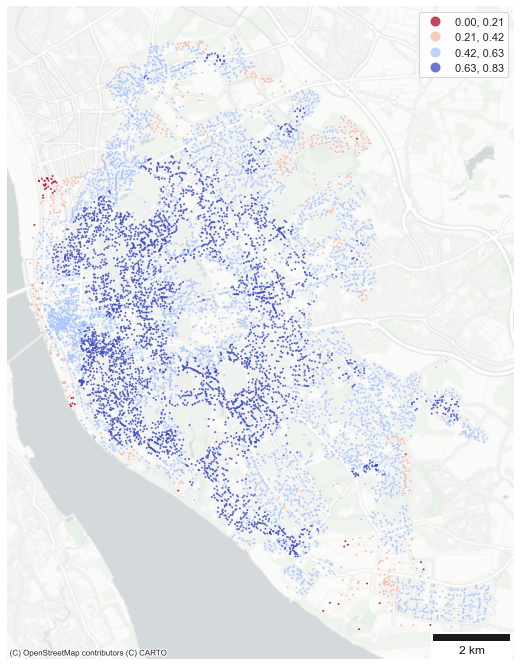

In [72]:
# generate static map
fig, ax1 = plt.subplots(figsize=(12,12))

ax1 = postcodes_access_adults.plot(
    ax=ax1,
    column='access_score',
    scheme='equal_interval',
    k=4,
    cmap='coolwarm_r',
    markersize=(1),
    alpha=0.75,
    legend=True
)

ax1.set_axis_off()
ax1.add_artist(ScaleBar(1,location='lower right'))
contextily.add_basemap(ax1, crs=postcodes_access_adults.crs.to_string(), 
                       zoom=12, 
                       source=contextily.providers.CartoDB.PositronNoLabels,
                       alpha=1.0
                       )
plt.savefig('image1.png', dpi=1080, bbox_inches='tight')


In [12]:
# # generate interactive map

# # prepare data
# q1 = postcodes_access_adults[postcodes_access_adults['access_score'] <= 0.21]
# q2 = postcodes_access_adults[(postcodes_access_adults['access_score'] > 0.21) & (postcodes_access_adults['access_score'] <= 0.42)]
# q3 = postcodes_access_adults[(postcodes_access_adults['access_score'] > 0.42) & (postcodes_access_adults['access_score'] <= 0.63)]
# q4 = postcodes_access_adults[postcodes_access_adults['access_score'] > 0.63]

# # set crs
# q1 = q1.to_crs('EPSG:4326')
# q2 = q2.to_crs('EPSG:4326')
# q3 = q3.to_crs('EPSG:4326')
# q4 = q4.to_crs('EPSG:4326')

In [13]:
# m = Map(center=(53.40901068828917, -2.99248119108002), zoom=12, basemap=basemaps.CartoDB.PositronNoLabels)
# q1_m = GeoData(geo_dataframe=q1,
#                    style={'color': 'black', 'radius':1.5, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    point_style={'radius': 0.5, 'color': '#0077b6', 'fillOpacity': 0.8, 'fillColor': '#0077b6', 'weight': 0.5}
#                    )

# q2_m = GeoData(geo_dataframe=q2,
#                    style={'color': 'black', 'radius':1.5, 'fillColor': 'red', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    point_style={'radius': 0.5, 'color': '#caf0f8', 'fillOpacity': 0.8, 'fillColor': '#caf0f8', 'weight': 0.5}
#                    )
# q3_m = GeoData(geo_dataframe=q3,
#                    style={'color': 'black', 'radius':1.5, 'fillColor': 'red', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    point_style={'radius': 0.5, 'color': '#fec89a', 'fillOpacity': 0.8, 'fillColor': '#fec89a', 'weight': 0.5}
#                    )
# q4_m = GeoData(geo_dataframe=q4,
#                    style={'color': 'black', 'radius':1.5, 'fillColor': 'red', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    point_style={'radius': 0.5, 'color': '#ade8f4', 'fillOpacity': 0.8, 'fillColor': '#ade8f4', 'weight': 0.5}
#                    )


# m.add_layer(q4_m)
# m.add_layer(q3_m)
# m.add_layer(q2_m)
# m.add_layer(q1_m)
# m.add_control(LayersControl())
# m

## For seniors

In [14]:
# number of amenities accessible per postcode
n_accessible = pd.DataFrame(od_pois_info_seniors.groupby('postcodeID').poiID.nunique()).reset_index().rename(columns={'poiID':'count'})

# variety of amenities accessible per postcode
v_accessible = pd.DataFrame(od_pois_info_seniors.groupby('postcodeID').classname.nunique()).reset_index().rename(columns={'classname':'variety'})

# minimum distance to each category from each postcode
min_dist_classname = pd.DataFrame(od_pois_info_seniors.groupby(['postcodeID','classname']).distance.min()).reset_index().rename(columns={'distance':'min_dist'})

# average distance to all categories from each postcode
avg_dist = pd.DataFrame(od_pois_info_seniors.groupby('postcodeID').distance.mean()).reset_index().rename(columns={'distance':'avg_dist'})

# average distance to each category from each postcode
avg_dist_classname = pd.DataFrame(od_pois_info_seniors.groupby(['postcodeID','classname']).distance.mean()).reset_index().rename(columns={'distance':'avg_dist'})
## calculate dimension index
index = pd.DataFrame(od_pois_info_seniors['postcodeID'].unique()).rename(columns={0:'postcodeID'})

# for number of amenities
n_accessible['n_accessible_index'] = (n_accessible['count'] - min(n_accessible['count'])) / (max(n_accessible['count']) - min(n_accessible['count']))

# for variety of amenities
v_accessible['v_accessible_index'] = (v_accessible['variety'] - min(v_accessible['variety'])) / (max(v_accessible['variety']) - min(v_accessible['variety']))

# for average distance
avg_dist['avg_dist_index'] = (avg_dist['avg_dist'] - min(avg_dist['avg_dist'])) / (max(avg_dist['avg_dist']) - min(avg_dist['avg_dist']))

## calculate composite index
index = pd.merge(index,n_accessible[['postcodeID','n_accessible_index']])
index = pd.merge(index,v_accessible[['postcodeID','v_accessible_index']])
index = pd.merge(index,avg_dist[['postcodeID','avg_dist_index']])

# index
index['access_score'] = ((index['n_accessible_index'] * index['v_accessible_index']) / (index['avg_dist_index'] + 1)).pow(1/3)
# add accessibility index info to postcodes
postcodes_access_seniors = pd.merge(postcodes, index)

#postcodes_access_seniors.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/results.gpkg', layer = 'index_seniors', driver = 'GPKG')


In [15]:
postcodes_access_adults.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/results.gpkg', layer='access_score_adults', driver='GPKG')

In [16]:
postcodes_access_seniors.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/results.gpkg', layer='access_score_seniors', driver='GPKG')

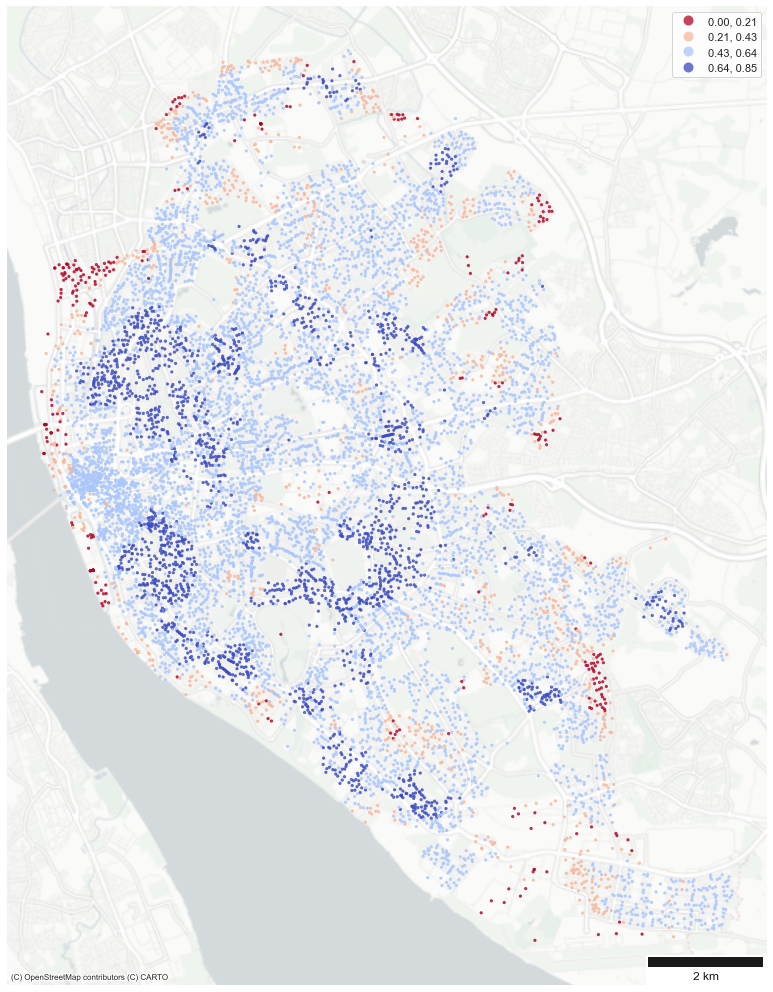

In [71]:
import contextily
# map postcodes' accessibility index
# using quantiles
ax2 = postcodes_access_seniors.plot(
    figsize=(18,18),
    column='access_score',
    scheme='equal_interval',
    k=4,
    cmap='coolwarm_r',
    legend=True,
    markersize=(5),
    alpha=0.75
)

ax2.set_axis_off()
ax2.add_artist(ScaleBar(1,location='lower right'))

contextily.add_basemap(ax2, crs=postcodes_access_seniors.crs.to_string(), 
                       zoom=12, 
                       source=contextily.providers.CartoDB.PositronNoLabels,
                       alpha=1.0
                       )
fig.add_axes(ax1)

plt.savefig('image2.png', dpi=1080,bbox_inches='tight')

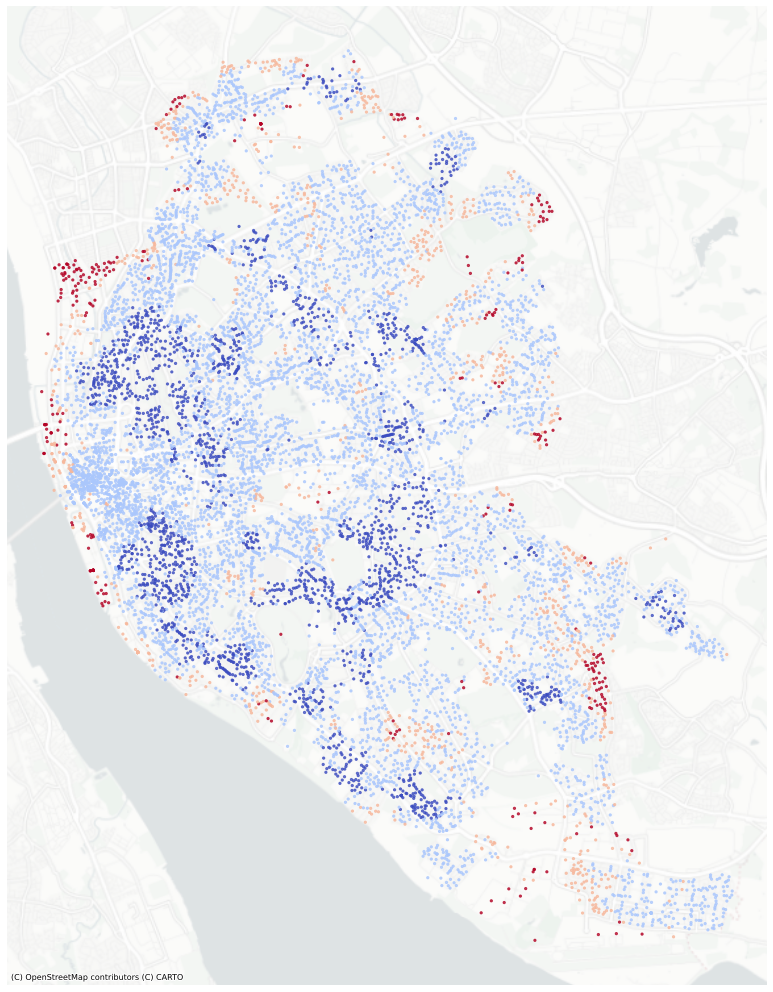

In [18]:
fig, ax2 = plt.subplots(figsize=(18,18))

ax2 = postcodes_access_seniors.plot(
    ax=ax2,
    column='access_score',
    scheme='equal_interval',
    k=4,
    cmap='coolwarm_r',
    markersize=(5),
    alpha=0.75,
    legend=False
)

ax2.set_axis_off()

contextily.add_basemap(ax2, crs=postcodes_access_adults.crs.to_string(), 
                       zoom=12, 
                       source=contextily.providers.CartoDB.PositronNoLabels,
                       alpha=.75
                       )

In [19]:
postcodes_access_seniors.head()

,postcodeID,Postcode,Positional_quality_indicator,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code,geometry,nodeID,n_accessible_index,v_accessible_index,avg_dist_index,access_score
0,0,L1 0AA,10,334864,389326,E92000001,E19000001,E18000002,None,E08000012,E05000907,POINT (334864.000 389326.000),25588,0.368421,1.0,0.681176,0.602898
1,1,L1 0AB,10,334943,389332,E92000001,E19000001,E18000002,None,E08000012,E05000907,POINT (334943.000 389332.000),41662,0.368421,1.0,0.708667,0.599647
2,2,L1 0AE,10,334667,389247,E92000001,E19000001,E18000002,None,E08000012,E05000907,POINT (334667.000 389247.000),40490,0.157895,1.0,0.708204,0.452143
3,3,L1 0AF,10,334771,389504,E92000001,E19000001,E18000002,None,E08000012,E05000907,POINT (334771.000 389504.000),23858,0.315789,1.0,0.690818,0.571611
4,4,L1 0AG,10,334903,389330,E92000001,E19000001,E18000002,None,E08000012,E05000907,POINT (334903.000 389330.000),25605,0.473684,1.0,0.719367,0.650689


# Shortest path

## For adults

In [20]:
# get origins and destinations nodes
ori_nodes = walk_streets_pdna.get_node_ids(od_pois_info_adults.geometry.x, od_pois_info_adults.geometry.y).values
dest_nodes = walk_streets_pdna.get_node_ids(od_pois_info_adults.geometry_pois.x, od_pois_info_adults.geometry_pois.y).values

# generate a list of pairs of oris and dests
od_nodes = list(zip(ori_nodes,dest_nodes))

# calculate all routes between each pair of oris and dests
%time
routes = []

for a,b in od_nodes:
    route = walk_streets_pdna.shortest_path(a,b)
    routes.append(route)
    
# add routes to the df
od_pois_info_adults['routes'] = routes

CPU times: total: 0 ns
Wall time: 0 ns


## For seniors

In [21]:
# get origins and destinations nodes
ori_nodes = walk_streets_pdna.get_node_ids(od_pois_info_seniors.geometry.x, od_pois_info_seniors.geometry.y).values
dest_nodes = walk_streets_pdna.get_node_ids(od_pois_info_seniors.geometry_pois.x, od_pois_info_seniors.geometry_pois.y).values

# generate a list of pairs of oris and dests
od_nodes = list(zip(ori_nodes,dest_nodes))

# calculate all routes between each pair of oris and dests
%time
routes = []

for a,b in od_nodes:
    route = walk_streets_pdna.shortest_path(a,b)
    routes.append(route)
    
# add routes to the df
od_pois_info_seniors['routes'] = routes

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
od_pois_info_adults.head()

,nodeID,distance,poiID,groupname,categoryname,classname,geometry_nodes,geometry_pois,postcodeID,Postcode,...,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code,geometry,routes
0,6200,1112.925049,6022,Park,Park,Park,POINT (340677.099 390446.825),POINT (340128.900 390586.570),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6149, 6145, 6146, 6148, 6151, 618..."
1,6200,1112.925049,6022,Park,Park,Park,POINT (340677.099 390446.825),POINT (340128.900 390586.570),2399,L14 3LT,...,340687,390435,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340687.000 390435.000),"[6200, 6201, 6149, 6145, 6146, 6148, 6151, 618..."
2,6200,535.765015,7005,Park,Park,Park,POINT (340677.099 390446.825),POINT (340859.730 390053.510),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 20..."
3,6200,535.765015,7005,Park,Park,Park,POINT (340677.099 390446.825),POINT (340859.730 390053.510),2399,L14 3LT,...,340687,390435,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340687.000 390435.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 20..."
4,6200,597.807983,7006,Park,Park,Park,POINT (340677.099 390446.825),POINT (341018.460 390159.600),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 16..."


In [23]:
#od_pois_info_adults.to_csv('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/od_pois_info_adults.csv', index=False)
#od_pois_info_seniors.to_csv('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/od_pois_info_seniors.csv', index=False)

# EDA

In [24]:
# accessibility scores by groupname
od_pois_info_adults.head()

,nodeID,distance,poiID,groupname,categoryname,classname,geometry_nodes,geometry_pois,postcodeID,Postcode,...,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code,geometry,routes
0,6200,1112.925049,6022,Park,Park,Park,POINT (340677.099 390446.825),POINT (340128.900 390586.570),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6149, 6145, 6146, 6148, 6151, 618..."
1,6200,1112.925049,6022,Park,Park,Park,POINT (340677.099 390446.825),POINT (340128.900 390586.570),2399,L14 3LT,...,340687,390435,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340687.000 390435.000),"[6200, 6201, 6149, 6145, 6146, 6148, 6151, 618..."
2,6200,535.765015,7005,Park,Park,Park,POINT (340677.099 390446.825),POINT (340859.730 390053.510),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 20..."
3,6200,535.765015,7005,Park,Park,Park,POINT (340677.099 390446.825),POINT (340859.730 390053.510),2399,L14 3LT,...,340687,390435,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340687.000 390435.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 20..."
4,6200,597.807983,7006,Park,Park,Park,POINT (340677.099 390446.825),POINT (341018.460 390159.600),2391,L14 3LH,...,340610,390495,E92000001,E19000001,E18000002,None,E08000012,E05000901,POINT (340610.000 390495.000),"[6200, 6201, 6202, 6168, 6167, 6166, 20375, 16..."


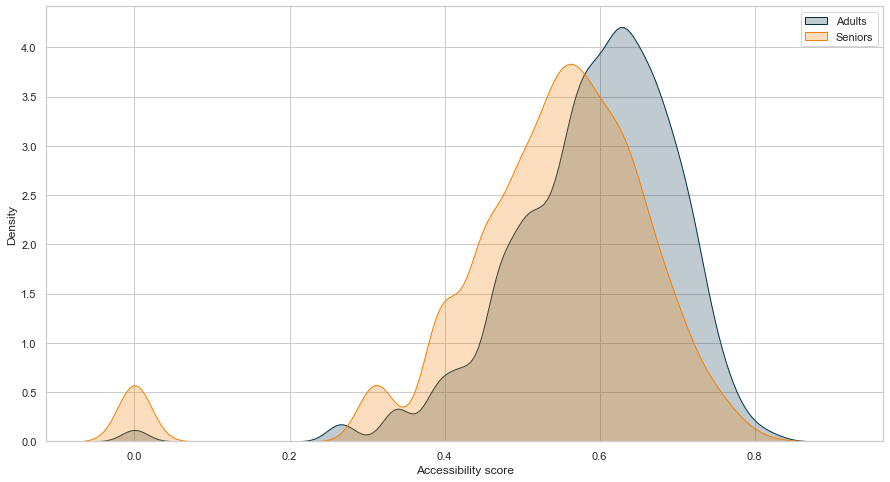

In [25]:
# set white grid
sns.set(style='whitegrid')

# figure size
plt.figure(figsize=(15,8))

# generate density plots for adults and seniors
fig = sns.kdeplot(postcodes_access_adults['access_score'], shade=True, color='#023047')
fig = sns.kdeplot(postcodes_access_seniors['access_score'], shade=True, color='#f77f00')

# customise labels
fig.set(xlabel='Accessibility score')

# legend
plt.legend(labels=['Adults','Seniors'])

plt.show()

### Spatial autocorrelation

In [26]:
pois_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5603 entries, 0 to 5602
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   groupname     5603 non-null   object  
 1   categoryname  5603 non-null   object  
 2   classname     5603 non-null   object  
 3   geometry      5603 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 218.9+ KB


In [84]:
pois_filtered[pois_filtered['groupname'] == 'Education and Health'].classname.unique()

array(['Chemists and Pharmacies', 'Doctors Surgeries',
       'First, Primary and Infant Schools',
       'Broad Age Range and Secondary State Schools', 'Hospitals'],
      dtype=object)

In [27]:
print(pois_filtered.groupname.unique())
print(pois_filtered.categoryname.unique())
print(pois_filtered.classname.unique())

['Transport' 'Sport and Entertainment' 'Education and Health' 'Retail'
 'Attractions']
['Bus Transport' 'Sports Complex'
 'Health Practitioners and Establishments' 'Venues, Stage and Screen'
 'Primary, Secondary and Tertiary Education'
 'Food, Drink and Multi Item Retail'
 'Public Transport, Stations and Infrastructure' 'Historical and Cultural']
['Bus Stops' 'Gymnasiums, Sports Halls and Leisure Centres'
 'Chemists and Pharmacies' 'Doctors Surgeries' 'Cinemas'
 'First, Primary and Infant Schools'
 'Convenience Stores and Independent Supermarkets'
 'Grocers, Farm Shops and Pick Your Own' 'Butchers' 'Supermarket Chains'
 'Fishmongers' 'Railway Stations, Junctions and Halts' 'Bakeries'
 'Broad Age Range and Secondary State Schools' 'Confectioners'
 'Delicatessens' 'Hospitals' 'Art Galleries' 'Theatres and Concert Halls']
